Выполнил: Урбанович Иван Олегович

Мультивариативный ряд: временные ряды метеорологических данных.<br>
Решаем задачу регресии. Предсказываем такие характеристики, как: атмосферное давление, температура воздуха, дефицит пара.
Замеры данных проводятся каждые 10 минут, период: 2009-2016 год.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from keras import Input, Model
from sklearn.model_selection import GridSearchCV
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler

my_seed = 42
torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

file_path = 'data/jena_climate_2009_2016.csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
selected_columns = ['Date', 'p (mbar)', 'T (degC)', 'VPdef (mbar)']
data = data[selected_columns]

Данные были обрезаны до 30000 в силу экономии времени. Как бы не хотелось, но огромное количество данных сильно влияет на скорость обучения моделей (даже тест Дики-Фуллера выполнялся 10 минут)

In [8]:
data = data[:30000]

# Блок предобработки временного ряда
## Свойства временных рядов

Просмотр основной информации о мультивариационном ряде

In [6]:
data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,28.07.2009 07:20:00,992.97,15.50,289.24,10.87,73.9,17.64,13.03,4.60,8.20,13.13,1192.39,1.77,3.38,259.5
29996,28.07.2009 07:30:00,993.03,15.49,289.23,10.90,74.1,17.62,13.06,4.56,8.22,13.15,1192.49,1.30,2.25,241.8
29997,28.07.2009 07:40:00,993.15,15.55,289.28,10.76,73.1,17.69,12.93,4.76,8.14,13.02,1192.45,1.57,2.75,234.6
29998,28.07.2009 07:50:00,993.23,15.73,289.45,10.85,72.7,17.90,13.01,4.89,8.19,13.10,1191.77,1.32,3.13,251.7


In [ ]:
data.describe()

,Date,p (mbar),T (degC),VPdef (mbar)
count,30000,30000.000000,30000.000000,30000.000000
mean,2009-04-15 04:05:00,988.088049,8.196780,3.595990
min,2009-01-01 00:10:00,944.580000,-23.010000,0.000000
25%,2009-02-22 02:07:30,983.460000,1.610000,0.760000
50%,2009-04-15 04:05:00,989.210000,8.660000,1.930000
75%,2009-06-06 06:02:30,994.280000,14.930000,5.120000
max,2009-07-28 08:00:00,1005.710000,27.880000,24.990000
std,NaN,9.074259,8.661805,4.001684


Графики временных рядов

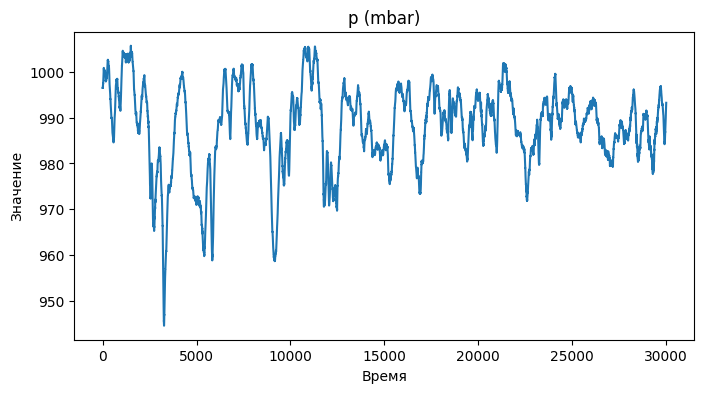

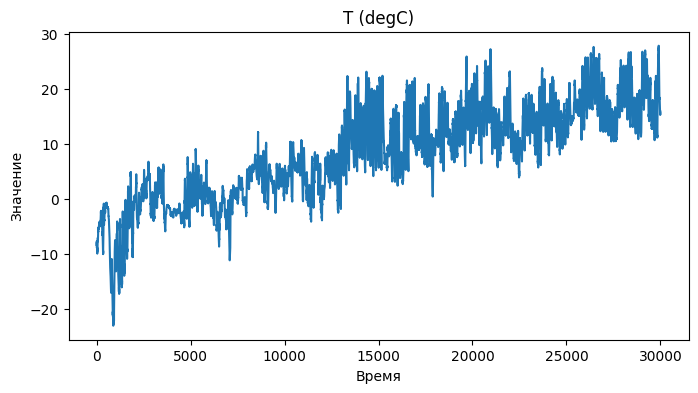

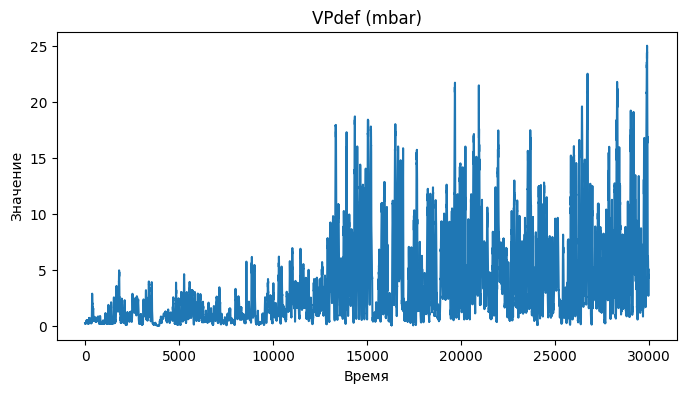

In [ ]:
columns = data.columns

for column in columns:
    if column != 'Date':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

Проверка на то, что все данные передаются через равный промежуток времени. Данные в датасете передаются через 10 минут.

In [ ]:
time_diff = data['Date'].diff()
time_diff.unique()

<TimedeltaArray>
[NaT, '0 days 00:10:00']
Length: 2, dtype: timedelta64[ns]

Просмотр пропущенных значений во временном ряде

In [ ]:
missing_values = data.isnull().sum()
missing_values

Date            0
p (mbar)        0
T (degC)        0
VPdef (mbar)    0
dtype: int64

### Проверка рядов на стационарность

In [ ]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [ ]:
for col in data.columns:
    if col != 'Date':
        df_test(col, data[col])

Тест Дики-Фуллера ряда p (mbar):
Test Statistic                -6.584921e+00
p-value                        7.355566e-09
#Lags Users                    5.000000e+01
Number of Observations Used    2.994900e+04
Critical Value (1%)           -3.430568e+00
Critical Value (5%)           -2.861637e+00
Critical Value (10%)          -2.566821e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда T (degC):
Test Statistic                -6.290397e+00
p-value                        3.611167e-08
#Lags Users                    5.000000e+01
Number of Observations Used    2.994900e+04
Critical Value (1%)           -3.430568e+00
Critical Value (5%)           -2.861637e+00
Critical Value (10%)          -2.566821e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда VPdef (mbar):
Test Statistic                   -19.903785
p-value                            0.000000
#Lags Users                       33.000000
Number of Observations Used    2996

Для прогнозирования в моделях VAR, VARMA важна стационарность.<br>
Для нейронок это уже необязательно.

### Коинтеграция

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [ ]:
del data['Date']

pairs = combinations(data.columns, 2)

for pair in pairs:
    pair_data = data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между p (mbar) и T (degC)
Есть коинтеграция между p (mbar) и VPdef (mbar)
Есть коинтеграция между T (degC) и VPdef (mbar)


### Причинность рядов по Грейнджеру

In [ ]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


,p (mbar)_x,T (degC)_x,VPdef (mbar)_x
p (mbar)_y,1.0,0.0,0.0
T (degC)_y,0.0,1.0,0.0
VPdef (mbar)_y,0.0,0.0,1.0


Если результат теста Грейнджера показывает строгое значение p-уровня значимости равное нулю или близкое к нулю (< 0.05) для пары временных рядов, это обычно интерпретируется как сильное статистическое доказательство в пользу наличия причинной связи между этими рядами. Ну и как итог - VAR модели подходят идеально.

## Прогнозирование временного ряда

#### VAR

VAR (Vector AutoRegression) - это тип статистической модели временных рядов, используемой для прогнозирования изменений в нескольких взаимосвязанных переменных с течением времени. Это многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Таким образом, все переменные в системе рассматриваются как эндогенные, и модель позволяет нам улучшить прогнозы путем учета взаимосвязей между переменными.

Для начала - подберем наилучший порядок, исходя из информационных критериев:<br>

AIC (Akaike Information Criterion)<br>
BIC (Bayesian Information Criterion)<br>
FPE (Final Prediction Error)<br>
HQC (Hannan-Quinn Criterion).<br>

Меньшие значения критериев указывают на лучшую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [ ]:
train, test = data[:25000], data[25000:]

model = VAR(train)

orders = [2,6,12,20,24,30,40,48,50,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 2
AIC :  -11.8601880139789 
BIC :  -11.85336116490643 
FPE :  7.06619781609136e-06 
HQIC:  -11.85797836706922  

Lag Order = 6
AIC :  -12.038424703547204 
BIC :  -12.019892084067424 
FPE :  5.912601113350924e-06 
HQIC:  -12.032426202735813  

Lag Order = 12
AIC :  -12.10419251149675 
BIC :  -12.068095074337469 *
FPE :  5.536253746410384e-06 
HQIC:  -12.092508626226174  

Lag Order = 20
AIC :  -12.115850157197633 
BIC :  -12.056321452897658 
FPE :  5.472088918368963e-06 
HQIC:  -12.096581829879185 * 

Lag Order = 24
AIC :  -12.116787603821534 
BIC :  -12.04553832968783 
FPE :  5.466961644580963e-06 
HQIC:  -12.093725370275777  

Lag Order = 30
AIC :  -12.117386714943782 
BIC :  -12.028550411594413 
FPE :  5.463687564069606e-06 
HQIC:  -12.088631514102083  

Lag Order = 40
AIC :  -12.118774515381741 
BIC :  -12.000610019165336 
FPE :  5.456111030164113e-06 
HQIC:  -12.080525410196966  

Lag Order = 48
AIC :  -12.119399751546144 
BIC :  -11.977757858016362 
FPE :  5.4527016361

Обучаем модель с наилучшим порядком (168)

In [ ]:
model_fitted = model.fit(168)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     00:06:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.6297
Nobs:                     24832.0    HQIC:                  -11.9647
Log likelihood:           46354.5    FPE:                5.42202e-06
AIC:                     -12.1251    Det(Omega_mle):     5.10424e-06
--------------------------------------------------------------------
Results for equation p (mbar)
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.230879         0.054958            4.201           0.000
L1.p (mbar)               1.351658         0.006460          209.224           0.000
L1.T (degC)               0.004154       

Теперь подготовим тестовые данные для предсказания, и сделаем их

In [ ]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [ ]:
X_test, Y_test = create_test_dataset(test, 168)
X_train, Y_train = create_train_dataset(train, 168)

In [ ]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [ ]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

Посчитаем метрики и отрисуем графики.

In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

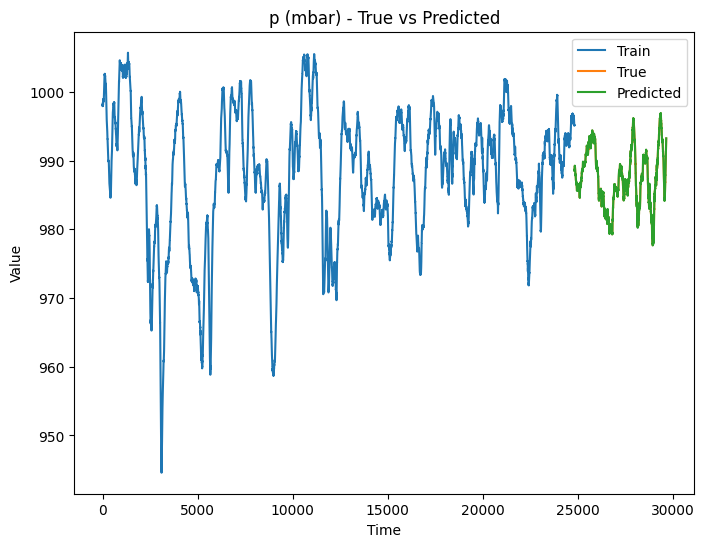

Метрики p (mbar)
MSE: 0.010905482302937197
RMSE: 0.10442931725783329
MAE: 0.0661532231764332
SMAPE: 0.0
R2: 0.9993756792556614 



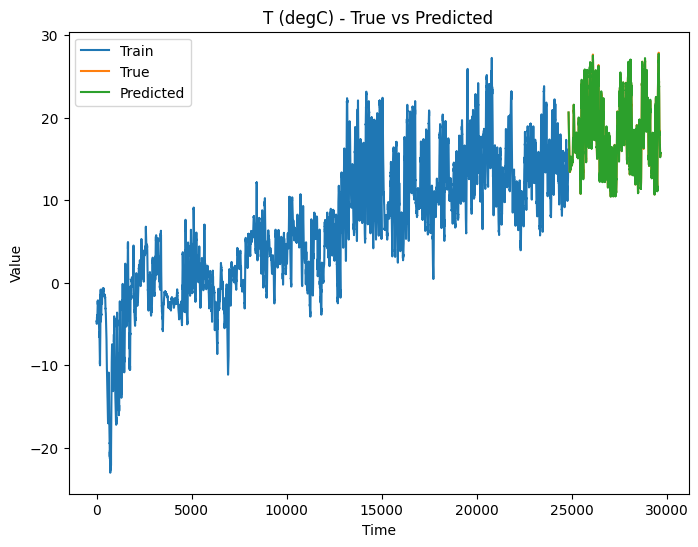

Метрики T (degC)
MSE: 0.06528069164627652
RMSE: 0.25550086427696583
MAE: 0.17184863445703674
SMAPE: 0.002
R2: 0.9961663134569136 



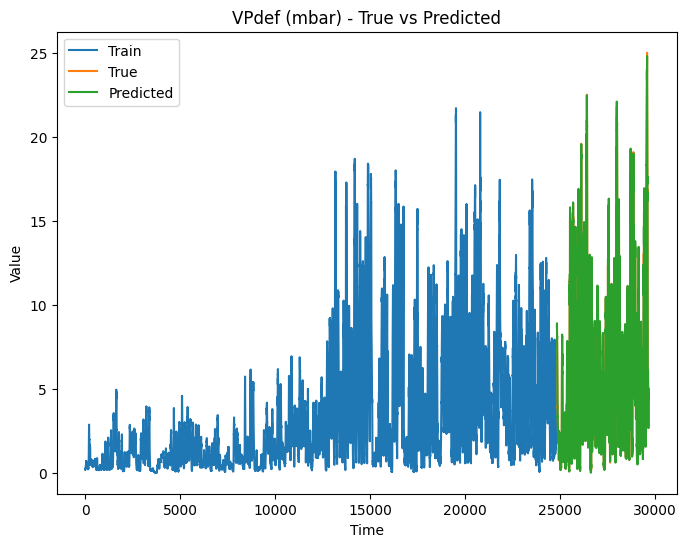

Метрики VPdef (mbar)
MSE: 0.16207263079503792
RMSE: 0.4025824521697859
MAE: 0.25089853280969054
SMAPE: 0.016
R2: 0.993526752965389 



In [ ]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

По метрикам:<br>

Адекватное MSE, RMSE, MAE - ниже единицы, что есть хорошо, близко к нулю.<br>
SMAPE тоже показывает себя неплохо (где-то в итоге около нуля, что идеально).<br>
R2 ~= 0.99, почти отлично, очень близко к единице.<br>

#### VARMA

VARMA (Vector AutoRegressive Moving-Average) - это стохастическая модель, используемая в области временных рядов для моделирования взаимосвязей между несколькими временными рядами одновременно. В этой модели предполагается, что каждый из временных рядов влияет на другие.

VARMA - это обобщение модели ARMA (AutoRegressive Moving Average). В модели ARMA каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный элемент) и ошибок прогнозирования (скользящая средняя).

Однако в модели VARMA каждый временной ряд моделируется не только на основе его собственных предыдущих значений, но и на основе предыдущих значений других временных рядов.

In [ ]:
X = data
train, test = X[:25000], X[25000:]

Подберём оптимальные параметры для обучения при помощи AutoArima.<br>

In [ ]:
pq = []
for name, column in data.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : p (mbar)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-63628.112, Time=6.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50395.007, Time=1.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61865.157, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58535.415, Time=7.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50396.974, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65152.035, Time=13.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62341.323, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-65291.819, Time=17.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63242.042, Time=1.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-65290.129, Time=29.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-65168.409, Time=23.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-65235.958, Time=6.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63798.106, Time=2.04 sec
 ARIMA(4,1,2)(0,0,0)[0] int

In [ ]:
pq

[(3, 1, 1), (5, 1, 2), (2, 1, 3)]

Подберем опытным путём наилучший порядок

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE p (mbar)','RMSE T (degC)','RMSE VPdef (mbar)'])
for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        p_mbar_srmse = np.sqrt(metrics.mean_squared_error(test['p (mbar)'], result['p (mbar)']))
        t_degc_rmse = np.sqrt(metrics.mean_squared_error(test['T (degC)'], result['T (degC)']))
        vpdef_mbar_rmse = np.sqrt(metrics.mean_squared_error(test['VPdef (mbar)'], result['VPdef (mbar)']))
        new_row = {'p': i[0], 'q': i[2], 'RMSE p (mbar)': p_mbar_srmse,'RMSE T (degC)': t_degc_rmse,'RMSE VPdef (mbar)': vpdef_mbar_rmse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Иван\AppData\Local\Temp\ipykernel_18196\3112505399.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Esti

In [ ]:
df_results_moni.sort_values(by = ['RMSE p (mbar)','RMSE T (degC)','RMSE VPdef (mbar)'] )

,p,q,RMSE p (mbar),RMSE T (degC),RMSE VPdef (mbar)
0,3,1,5.111150,10.221330,5.502208
1,5,2,5.173688,10.890805,5.568580
2,2,3,5.189430,10.258954,5.501533


Наилучшие p, q - 3,1

In [ ]:
model = VARMAX(train, order=(3,1)).fit(disp=False)
result = model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Посмотрим на полученный результат

In [ ]:
result

,p (mbar),T (degC),VPdef (mbar)
25000,995.001994,16.414210,6.784656
25001,994.943758,16.475280,6.828948
25002,994.901021,16.507595,6.856157
25003,994.868164,16.523290,6.871447
25004,994.842872,16.529445,6.879133
...,...,...,...
29995,988.625279,6.564182,3.231969
29996,988.625040,6.564003,3.231902
29997,988.624802,6.563824,3.231836
29998,988.624564,6.563646,3.231769


Считаем метрики и отрисовываем предсказания.

In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

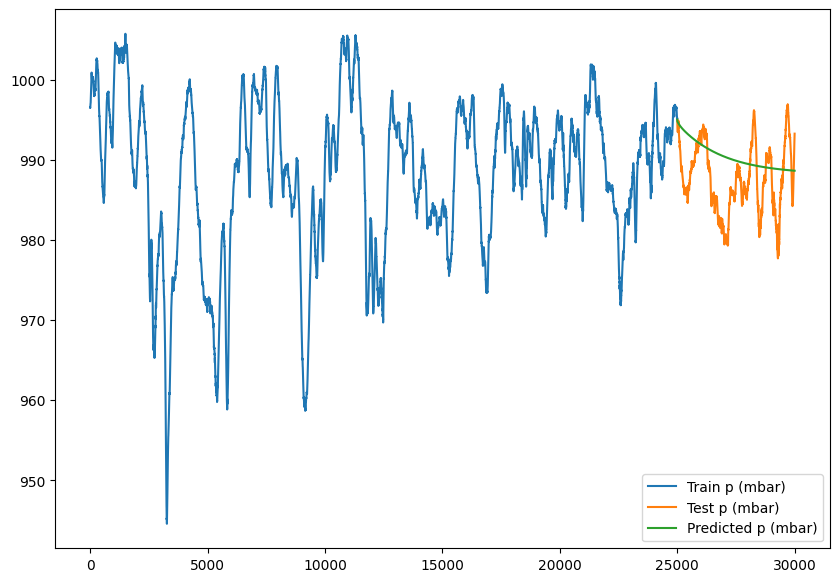

Evaluation metric for p (mbar)
MSE: 26.12384820117567
MAE: 4.268660640187485
RMSE: 5.111149401179315
SMAPE: 0.001
R2: -0.4666108451817499



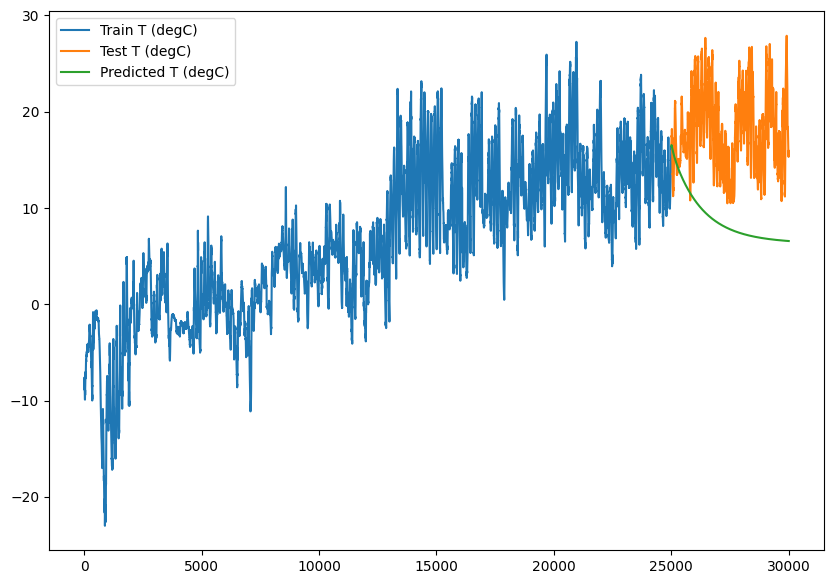

Evaluation metric for T (degC)
MSE: 104.47572576276801
MAE: 9.046917379654106
RMSE: 10.221336789420844
SMAPE: 0.167
R2: -5.1798011656348635



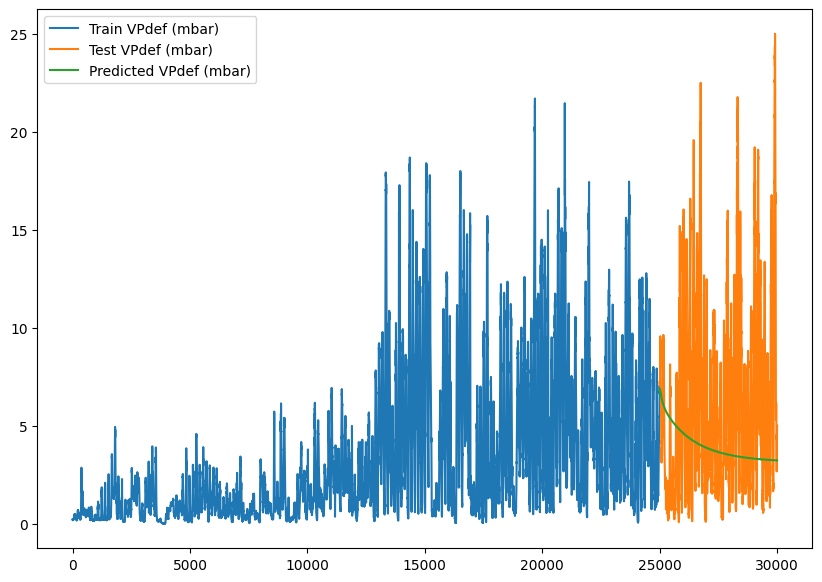

Evaluation metric for VPdef (mbar)
MSE: 30.274297490165672
MAE: 4.010437762209526
RMSE: 5.502208419368142
SMAPE: 0.19
R2: -0.24364047734333938



In [ ]:
for i in ['p (mbar)', 'T (degC)', 'VPdef (mbar)']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(25000, 30000), test[str(i)], label='Test '+str(i))
    plt.plot(range(25000, 30000), result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , result[str(i)])

На последней метрике MSE, RMSE - удовлетворельны, MAE показал неплохой результат, SMAPE не так идеален, но тоже более менее удовлетворителен, R2 - отрицателен, поэтому это плохо.<br>

Первая метрика дала удовлетворительный MSE, RMSE, хороший MAE, хороший SMAPE, но опять же отрицательный R2, что опять же плохо.<br>

Со второй метрикой всё куда хуже: MSE, RMSE оставляют желать лучше (MSE > 100, могло быть и лучше, MAE - неплохой результат, SMAPE тоже оставляет желать лучшего, но более менее удовлетворителен, R2 - отрицателен, но уже его значение ниже, чем для других рядов, что ещё хуже.<br>

Как итог - метрики удовлетворительны, но на самом деле они оставляют желать лучшего.

## Нейросети

#### LSTM

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), разработанный для работы с последовательными данными, такими как временные ряды, тексты, аудио и другие последовательные данные.

Основная особенность LSTM заключается в способности учитывать зависимости и долгосрочные зависимости в данных, что часто бывает сложно для обычных RNN. Они обладают способностью запоминать информацию на протяжении длительных временных интервалов и избегать проблемы затухания/взрыва градиентов, которая часто встречается у обычных RNN.

Подготовим данные и отмасштабируем их для обучения.

In [ ]:
df_LSTM = pd.DataFrame(data['Date'])
df_LSTM['p (mbar)'] = data['p (mbar)']
df_LSTM['T (degC)'] = data['T (degC)']
df_LSTM['VPdef (mbar)'] = data['VPdef (mbar)']
df_LSTM.set_index('Date', inplace=True)

lookback_window = 1

df_LSTM = df_LSTM.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_LSTM[i - lookback_window:i])
    y.append(df_LSTM[i])
x = np.array(x)
y = np.array(y)

In [ ]:
x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:]
y_test = y[25000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)

Определим саму модель и обучим её.

In [ ]:
i = Input(shape=(lookback_window, 3))
m = LSTM(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 90)                33840     
                                                                 
 dense (Dense)               (None, 3)                 273       
                                                                 
Total params: 34113 (133.25 KB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

Сделаем предсказания и вернём значения к исходному масштабу, посчитаем метрики и отрисуем прогнозы.

In [ ]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3)).reshape(y_pred_scaled.shape)

157/157 [==============================] - 1s 3ms/step


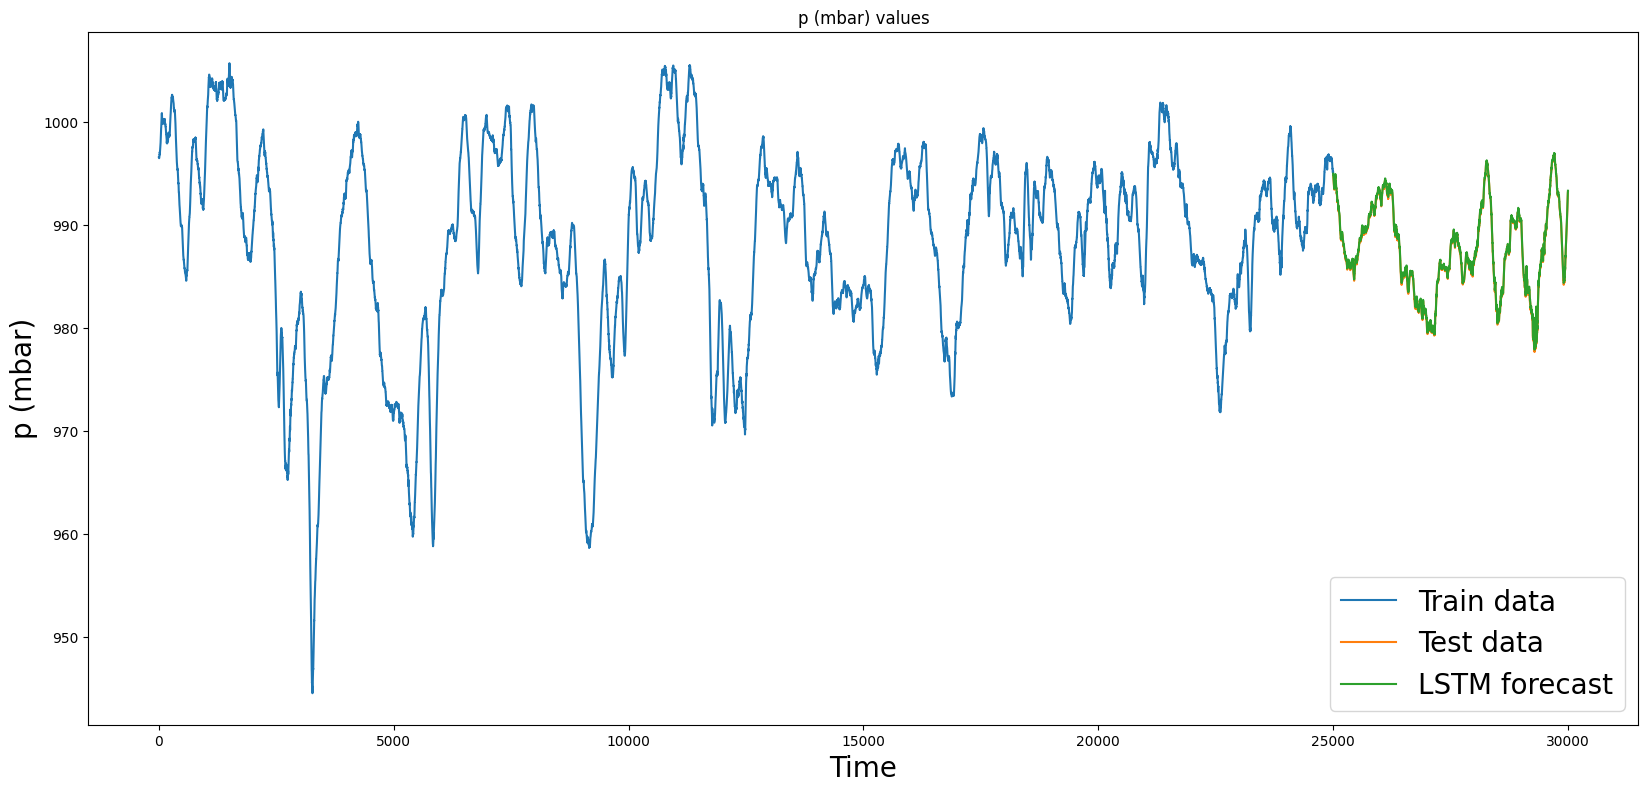

LSTM Metrics p (mbar):
RMSE: 0.165508939529166
MSE: 0.02739320906406913
SMAPE: 0.0
MAE: 0.13382625353195768
R^2: 0.9984615138010244


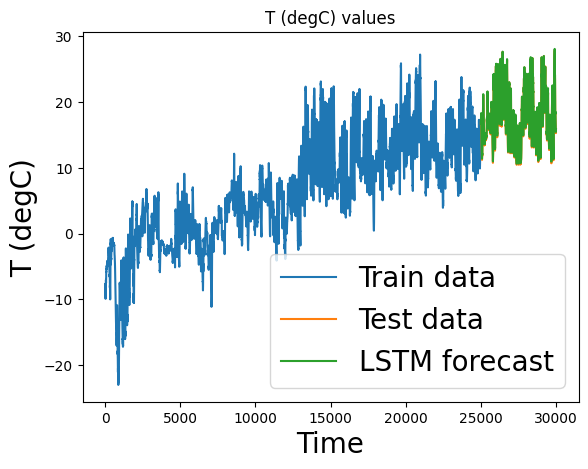

LSTM Metrics T (degC):
RMSE: 0.3296360678667718
MSE: 0.10865993723866697
SMAPE: 0.004
MAE: 0.2520796789439064
R^2: 0.9935738778383316


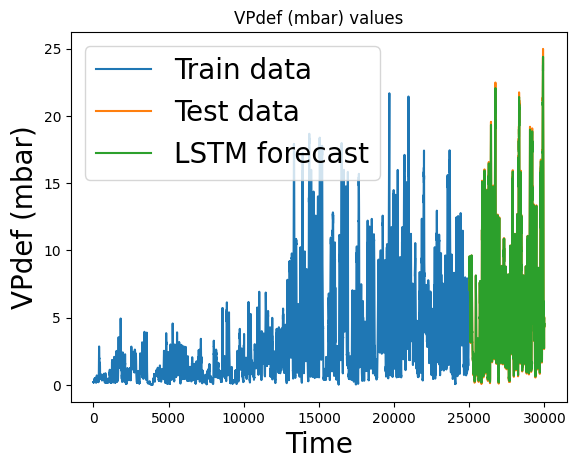

LSTM Metrics VPdef (mbar):
RMSE: 0.46020041172149945
MSE: 0.2117844189486376
SMAPE: 0.02
MAE: 0.2998405734228597
R^2: 0.9913017438901477


In [ ]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['p (mbar)', 'T (degC)', 'VPdef (mbar)']

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Метрики примерно одинаковые, но они просто отличные.<br>
RMSE, MSE, MAE < 1 и очень близок к нулю, что почти идеально.<br>
SMAPE < 1 и где-то даже очень близок к нулю, что почти идеально.<br>
R2 с небольшими погрешностями можно назвать идеальным.<br>

#### GRU

GRU (Gated Recurrent Units) - это один из типов рекуррентных нейронных сетей, предложенный в 2014 году. Он был создан как более простая альтернатива LSTM (Long Short-Term Memory), другому типу рекуррентных сетей.

Главной отличительной особенностью GRU является меньшее число элементов управления или "ворот". У LSTM есть три ворота: входное, забывающее и выходное, а у GRU - всего два: обновляющее и сбрасывающее.

Обновляющее ворото в модели GRU определяет, какую часть предыдущего состояния следует сохранить, а сбрасывающее ворото контролирует, как много прошлого состояния использовать для вычисления текущего состояния.

По сути, GRU пытается решить проблему памяти в обычных рекуррентных сетях, взяв наиболее эффективные элементы LSTM, но упростив их. И, хотя GRU модели обычно требуют меньше объема вычислений по сравнению с LSTM, их эффективность сильно зависит от конкретной задачи.

Определим данные и масштабируем их.

In [ ]:
df_GRU = pd.DataFrame(data['Date'])
df_GRU['p (mbar)'] = data['p (mbar)']
df_GRU['T (degC)'] = data['T (degC)']
df_GRU['VPdef (mbar)'] = data['VPdef (mbar)']
df_GRU.set_index('Date', inplace=True)

lookback_window = 1

df_GRU = df_GRU.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_GRU[i - lookback_window:i])
    y.append(df_GRU[i])
x = np.array(x)
y = np.array(y)

In [ ]:
x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:]
y_test = y[25000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)

Определим саму модель и обучим её.

In [ ]:
i = Input(shape=(lookback_window, 3))
m = GRU(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 gru (GRU)                   (None, 90)                25650     
                                                                 
 dense_1 (Dense)             (None, 3)                 273       
                                                                 
Total params: 25923 (101.26 KB)
Trainable params: 25923 (101.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

Сделаем предсказания и вернём значения к исходному масштабу, посчитаем метрики и отрисуем прогнозы.

In [ ]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3)).reshape(y_pred_scaled.shape)

157/157 [==============================] - 1s 2ms/step


Сделаем предсказания для модели на тестовой выборке.

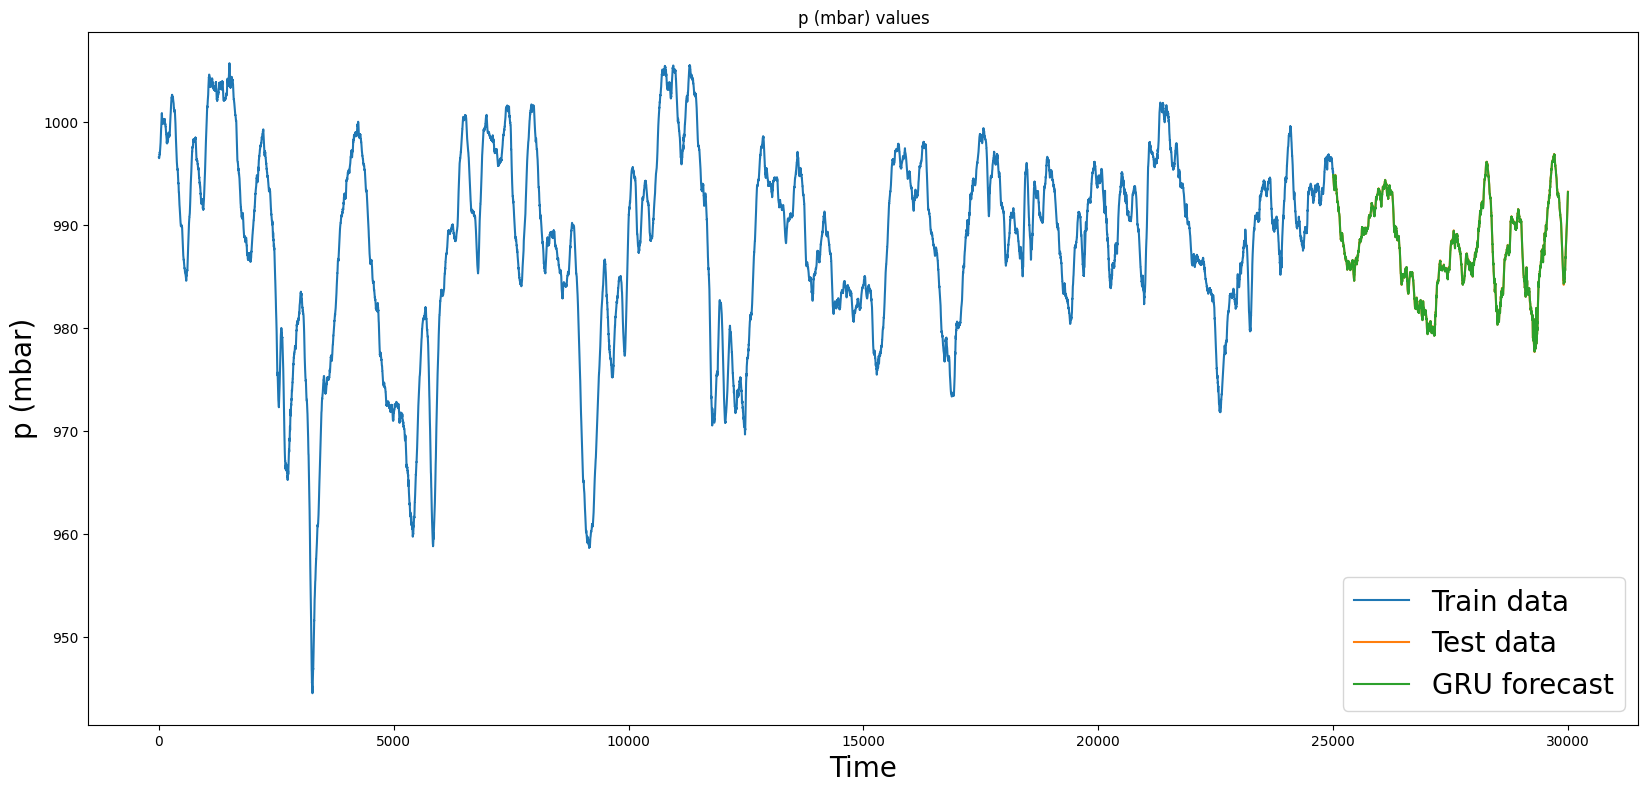

GRU Metrics p (mbar):
RMSE: 0.1153871130561547
MSE: 0.013314185859433827
SMAPE: 0.0
MAE: 0.07607402486356601
R^2: 0.9992522346999424


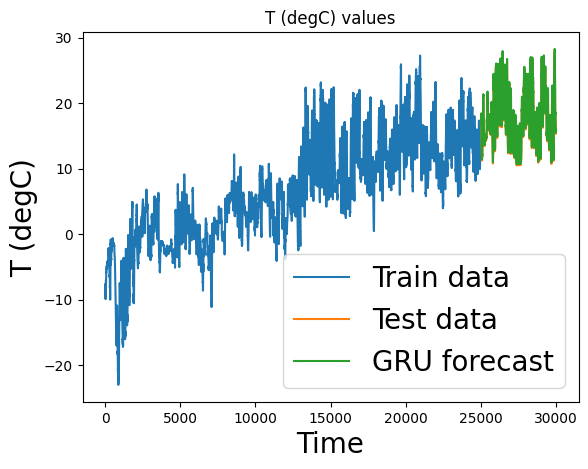

GRU Metrics T (degC):
RMSE: 0.3595021613290098
MSE: 0.1292418040002294
SMAPE: 0.004
MAE: 0.2807195717784304
R^2: 0.9923566712626046


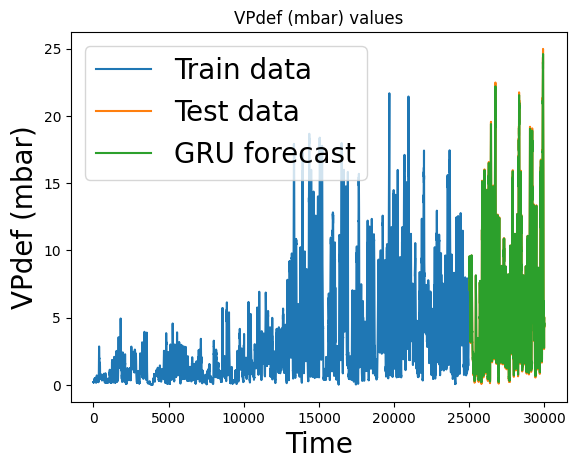

GRU Metrics VPdef (mbar):
RMSE: 0.4602972486152578
MSE: 0.21187355708277641
SMAPE: 0.022
MAE: 0.30442710901456105
R^2: 0.9912980828733281


In [ ]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['p (mbar)', 'T (degC)', 'VPdef (mbar)']

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"GRU Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Метрики примерно одинаковые, но они просто отличные.<br>
RMSE, MSE, MAE < 1 и очень близок к нулю, что почти идеально.<br>
SMAPE < 1 и где-то даже очень близок к нулю, что почти идеально.<br>
R2 с небольшими погрешностями можно назвать идеальным.<br>

В целом показала такой же результат, как и LSTM.

#### TCN

TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

Подготовим данные.

In [9]:
df_tcn = pd.DataFrame(data['Date'])
df_tcn['p (mbar)'] = data['p (mbar)']
df_tcn['T (degC)'] = data['T (degC)']
df_tcn['VPdef (mbar)'] = data['VPdef (mbar)']
df_tcn.set_index('Date', inplace=True)

lookback_window = 20

df_tcn = df_tcn.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

Делим данные на обучающую и тестовые выборки

In [10]:
x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:]
y_test = y[25000:]

Определим модель и обучим её.

In [11]:
i = Input(shape=(lookback_window, 3))
m = TCN()(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 tcn (TCN)                   (None, 64)                136768    
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 136963 (535.01 KB)
Trainable params: 136963 (535.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.fit(x_train, y_train, epochs=100, verbose=0)

Делаем предикты

In [16]:
y_pred = model.predict(x_test)

156/156 [==============================] - 2s 11ms/step


Отрисуем предсказания с истинными метками, покажем на графике и посчитаем метрики.

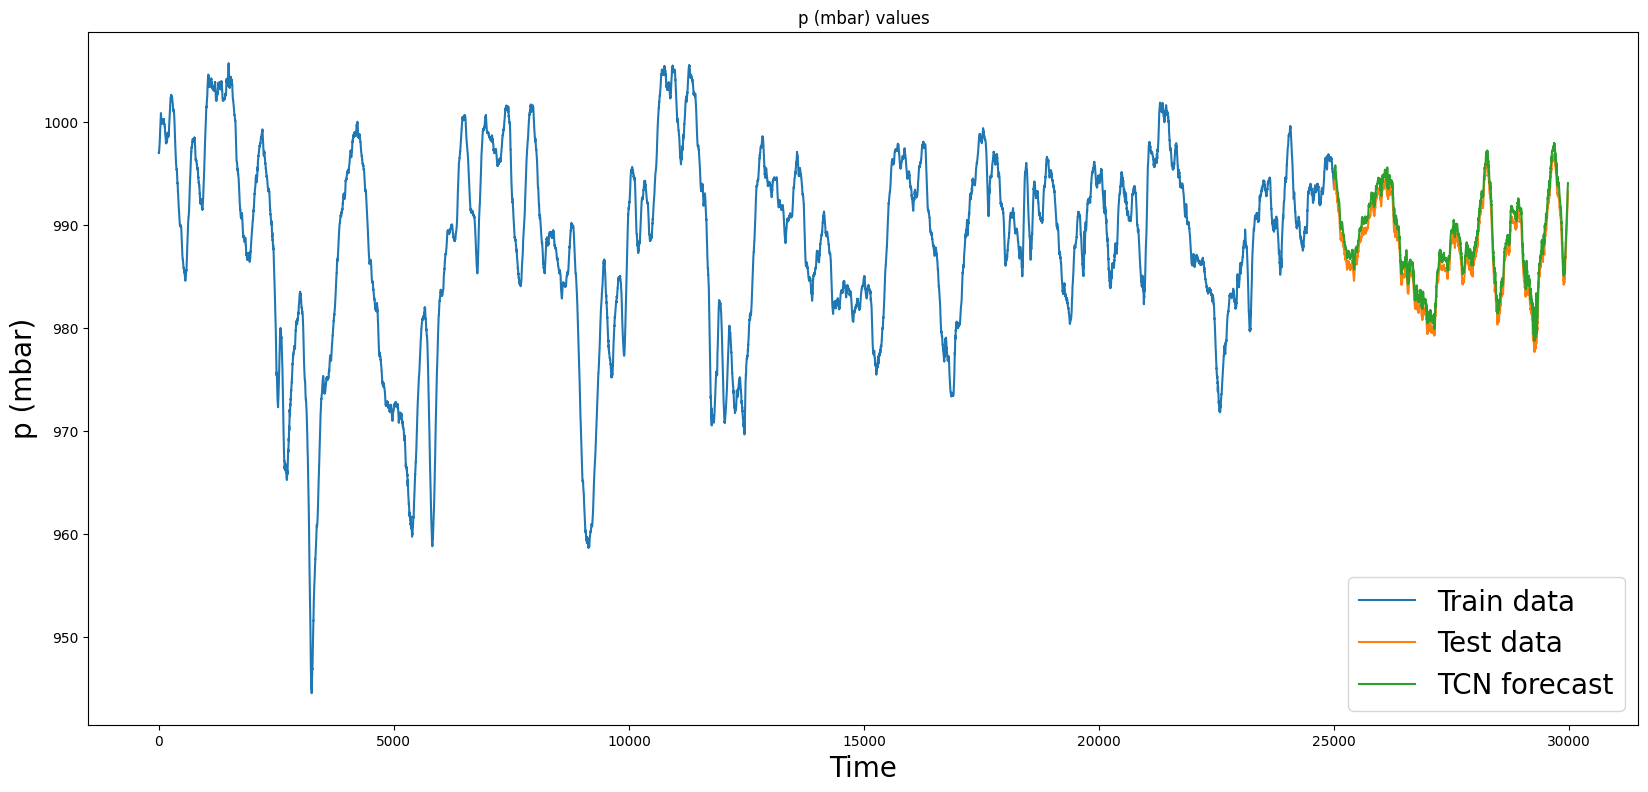

TCN Metrics p (mbar):
RMSE: 1.0418173523128116
MSE: 1.085383395580077
SMAPE: 0.0
MAE: 1.0219224652516326
R^2: 0.9386809936206512


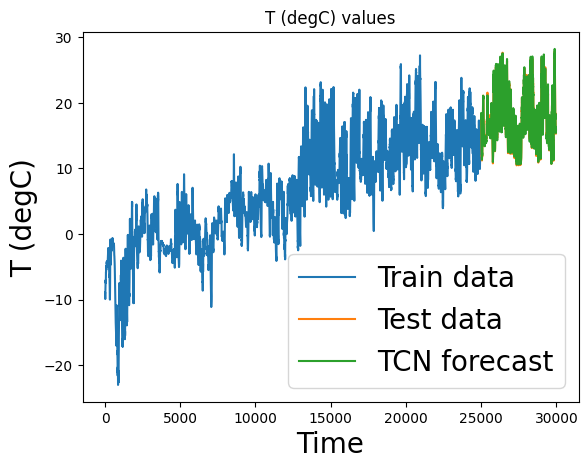

TCN Metrics T (degC):
RMSE: 0.5170670722371566
MSE: 0.267358357191905
SMAPE: 0.006
MAE: 0.3878269676836619
R^2: 0.9842472859937547


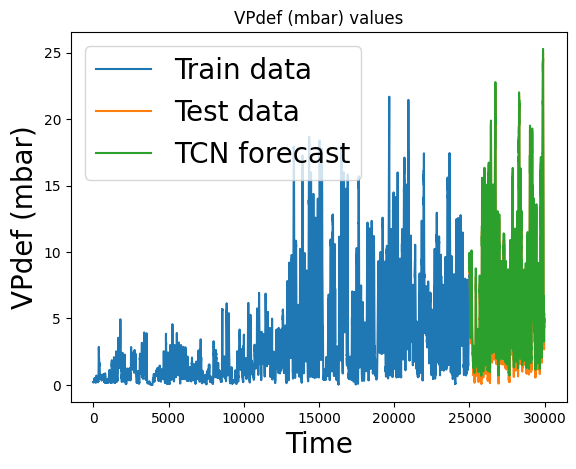

TCN Metrics VPdef (mbar):
RMSE: 0.672639612803248
MSE: 0.4524440487121035
SMAPE: 0.052
MAE: 0.5638172746834506
R^2: 0.9814788756396375


In [17]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['p (mbar)', 'T (degC)', 'VPdef (mbar)']

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"TCN Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

RMSE, MSE, MAE < 1, где-то в районе 1 - почти отличный результат.<br>
SMAPE ниже единицы и опять очень близок к нулю, а где-то и вовсе ноль что очень хорошо.<br>
R2 > 0.9, близок к единице, хороший результат.<br>

По результату показала себя чуть хуже, чем LSTM и GRU, но при этом не нужно было масштабировать исходные данные.

## Итог

Среди классических моделей лучше себя показала VAR. Она очень быстро подбирала оптимальные параметры для обучения и очень быстро обучалась, к тому же прогнозы были качественны, как в итоге и сама модель.<br>

Не до конца понятно, почему VARMAX показал плохое качество, но возможно дело было в подборе параметров (параметры из VAR можно было бы интерпретировать на VARMA, но обучение бы длилось очень долго и не факт, что оно было дало хоть какие-то положительные результаты).

Если выделять среди нейронок, то выбор складывается больше в пользу LSTM/GRU за счёт простоты настройки и обучения модели. TCN также хороша тем, что показала очень хороший результат на данных, которые не были отмасштабированы, что является очень хорошим показателем.

Ну и в итоге: нейросеть показала себя лучше классических алгоритмов, за счёт того, что в них не нужно особым образом подготавливать данные, дифференцировать ряды, чтобы сделать их стационарными (хоть и в данной задаче это не потребовалось), поскольку и без этого они выдают отличное качество и при этом предсказанные данные не искажаются (так как никакого дифференцирования для них нету).